In [1]:
import pandas as pd
import warnings
#import exceptions

warnings.filterwarnings(action='default')

class Loader:
    def __init__(self, csv_file: str):
        self.csv_file = csv_file
        self.prices = self._read_csv()

    def _read_csv(self):
        prices = pd.read_csv(self.csv_file, index_col=0, parse_dates=True)
        return prices

    def load_data(self, start_date: str, end_date: str):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        return self.prices.loc[start_date:end_date]

    def get_prices(self, assets: list = None):
        if assets is not None:
            return self.prices[assets]
        return self.prices


In [2]:
from typing import List, Optional, Dict, Any, Tuple, Callable, Union
import numpy as np
import collections
import pandas as pd
import json

class Node:
    def __init__(self, name: str, **params: Any):
        self.name = name
        self.children: List[Node] = []
        self.params = params
        self.params['weight_bounds'] = params.get('weight_bounds', (0, 1))

    def add_child(self, child_node) -> None:
        self.children.append(child_node)
        
class Tree:
    def __init__(self, root_name: str):
        self.root = Node(root_name)
        #self.assumption = AssetAssumption

    def __repr__(self) -> str:
        return f'Tree({self.root.name})'

    def insert(self, parent_name: str, child_name: str, **params: Any) -> bool:
        parent_node = self._find_node(self.root, parent_name)
        if parent_node:
            child_node = Node(child_name, **params)
            parent_node.add_child(child_node)
            return True
        return False

    def draw(self) -> None:
        lines = self._build_tree_string(self.root, '')
        print('\n'.join(lines))

    def _find_node(self, node: Node, target_name: str) -> Optional[Node]:
        if node.name == target_name:
            return node
        for child in node.children:
            found_node = self._find_node(child, target_name)
            if found_node:
                return found_node
        return None

    def _build_tree_string(self, node: Node, prefix: str, is_tail: bool = True):
        lines = []
        line = f"{prefix}{'`-- ' if is_tail else '|-- '}{node.name}"
        lines.append(line)
        prefix += '    ' if is_tail else '|   '
        child_count = len(node.children)
        for i, child in enumerate(node.children):
            is_last_child = i == child_count - 1
            lines.extend(self._build_tree_string(child, prefix, is_last_child))
        return lines  # Add the missing return statement
    
    def get_all_nodes(self) -> List[Node]:
        return self._collect_nodes(self.root, [])

    def _collect_nodes(self, node: Node, node_list: List[Node]) -> List[Node]:
        for child in node.children:
            node_list.append(child)
            self._collect_nodes(child, node_list)
        return node_list
    

In [3]:
from datetime import datetime, timedelta
from typing import Callable, Any
from copy import deepcopy

class AssetAssumption:
    def __init__(self, **params: Any):
        self.param_dict = params
        self.param_key = [key for key in params.keys()]

        self.param = {}
        self.max_window = 0
        
    def get_data(self, loader: Loader, start_date, end_date):
        # Extract the maximum window from the input parameters
        for key in self.param_key:
            _, kwargs = self.param_dict[key]
            if 'window' in kwargs and kwargs['window'] > self.max_window:
                self.max_window = kwargs['window']

        start_date = self.base_date(loader, start_date, self.max_window)

        price_data = loader.load_data(start_date-timedelta(days=10), end_date)
        self.compute_parameters(price_data)
        
        return self.param
        
    def compute_parameters(self, price_data):
        #weekly_price = deepcopy(price_data.resample('w').last())
        daily_rtn = price_data.pct_change(periods=5).dropna()
        for keys in self.param_key:
            func, kwargs = self.param_dict[keys]
            self.param[keys] = func(daily_rtn, **kwargs)
        
    def base_date(self, loader: Loader, start_date, window):
        start_date = start_date - timedelta(days=window+6)
        return start_date
    
    
def historical_return(daily_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(daily_rtn_data, pd.DataFrame):
        historical_return = daily_rtn_data.rolling(window=window).mean() * 52 * 100
        return historical_return.dropna()
    

def historical_variance(daily_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(daily_rtn_data, pd.DataFrame):
        historical_var = daily_rtn_data.rolling(window=window).std() * np.sqrt(52)
        return historical_var.dropna()

def historical_covariance(daily_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(daily_rtn_data, pd.DataFrame):
        historical_cov = daily_rtn_data.rolling(window=window).cov() * np.sqrt(52) * 100
        return historical_cov.dropna()
    
    
"""
assumption = AssetAssumption(returns=(historical_return, {'window': 20}), 
                             covariance=(historical_covariance, {'window': 60}))
"""

"\nassumption = AssetAssumption(returns=(historical_return, {'window': 20}), \n                             covariance=(historical_covariance, {'window': 60}))\n"

In [4]:
"""from datetime import datetime, timedelta
from typing import Callable, Any
from copy import deepcopy

class AssetAssumption:
    def __init__(self, **params: Any):
        self.param_dict = params
        self.param_key = [key for key in params.keys()]

        self.param = {}
        self.max_window = 0
        
    def get_data(self, loader: Loader, start_date, end_date):
        # Extract the maximum window from the input parameters
        for key in self.param_key:
            _, kwargs = self.param_dict[key]
            if 'window' in kwargs and kwargs['window'] > self.max_window:
                self.max_window = kwargs['window']

        start_date = self.base_date(loader, start_date, self.max_window)

        price_data = loader.load_data(start_date-timedelta(days=10), end_date)
        self.compute_parameters(price_data)
        
        return self.param
        
    def compute_parameters(self, price_data):
        daily_rtn = price_data.pct_change()
        weekly_rtn = (daily_rtn + 1).resample('W').prod() - 1
        for keys in self.param_key:
            func, kwargs = self.param_dict[keys]
            self.param[keys] = func(weekly_rtn, **kwargs)
        
    def base_date(self, loader: Loader, start_date, window):
        start_date = start_date - timedelta(days=window+6)
        return start_date
    
    
def historical_return(weekly_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(weekly_rtn_data, pd.DataFrame):
        historical_return = weekly_rtn_data.rolling(window=window).mean() * 52 * 100
        return historical_return.dropna()
    

def historical_variance(weekly_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(weekly_rtn_data, pd.DataFrame):
        historical_var = weekly_rtn_data.rolling(window=window).std() * np.sqrt(52)
        return historical_var.dropna()

def historical_covariance(weekly_rtn_data:Optional[pd.DataFrame]=None, window=4):
    if isinstance(weekly_rtn_data, pd.DataFrame):
        historical_cov = weekly_rtn_data.rolling(window=window).cov() * np.sqrt(52) * 100
        return historical_cov.dropna()"""


"from datetime import datetime, timedelta\nfrom typing import Callable, Any\nfrom copy import deepcopy\n\nclass AssetAssumption:\n    def __init__(self, **params: Any):\n        self.param_dict = params\n        self.param_key = [key for key in params.keys()]\n\n        self.param = {}\n        self.max_window = 0\n        \n    def get_data(self, loader: Loader, start_date, end_date):\n        # Extract the maximum window from the input parameters\n        for key in self.param_key:\n            _, kwargs = self.param_dict[key]\n            if 'window' in kwargs and kwargs['window'] > self.max_window:\n                self.max_window = kwargs['window']\n\n        start_date = self.base_date(loader, start_date, self.max_window)\n\n        price_data = loader.load_data(start_date-timedelta(days=10), end_date)\n        self.compute_parameters(price_data)\n        \n        return self.param\n        \n    def compute_parameters(self, price_data):\n        daily_rtn = price_data.pct_chang

In [5]:
import collections
import copy

class InstantiationError(Exception):
    pass

class OptimizationError(Exception):
    pass


In [6]:
def get_covariance_matrix(nodes):
    cov_dict = {}

    node_names = [node.name for node in nodes]  # Get the names of the nodes in the list
    
    for node in nodes:
        if 'covariance' in [i for i in node.params.keys()]:
            pass
        else:
            print('공분산 정보가 없습니다')
            return None

    for node in nodes:
        cov_series = node.params['covariance']
        # Select only the covariances for the nodes in the list
        selected_covariances = cov_series[cov_series.index.isin(node_names)]
        cov_dict[node.name] = selected_covariances

    cov_matrix = pd.DataFrame(cov_dict)

    cov_matrix = cov_matrix.T.fillna(cov_matrix).T

    cov_matrix = (cov_matrix + cov_matrix.T) / 2

    print(cov_matrix)
    return cov_matrix * 100


In [7]:
import copy
import cvxpy as cp
import scipy.optimize as sco

class BaseOptimizer:
    
    def __init__(self, n_assets, tickers=None):
        self.n_assets = n_assets
        if tickers is None:
            self.tickers = list(range(n_assets))
        else:
            self.tickers = tickers
        self._risk_free_rate = None
        # Outputs
        self.weights = None

    def _make_output_weights(self, weights=None):
        if weights is None:
            weights = self.weights

        return collections.OrderedDict(zip(self.tickers, weights))

    def set_weights(self, input_weights):
        self.weights = np.array([input_weights[ticker] for ticker in self.tickers])

    def clean_weights(self, cutoff=1e-4, rounding=5):
        if self.weights is None:
            raise AttributeError("Weights not yet computed")
        clean_weights = self.weights.copy()
        clean_weights[np.abs(clean_weights) < cutoff] = 0
        if rounding is not None:
            if not isinstance(rounding, int) or rounding < 1:
                raise ValueError("rounding must be a positive integer")
            clean_weights = np.round(clean_weights, rounding)

        return self._make_output_weights(clean_weights)


class BaseConvexOptimizer(BaseOptimizer):

    def __init__(
        self,
        n_assets,
        tickers=None,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):

        super().__init__(n_assets, tickers)

        # Optimization variables
        self._w = cp.Variable(n_assets)
        self._objective = None
        self._additional_objectives = []
        self._constraints = []
        self._lower_bounds = None
        self._upper_bounds = None
        self._opt = None
        self._solver = solver
        self._verbose = verbose
        self._solver_options = solver_options if solver_options else {}
        self._map_bounds_to_constraints(weight_bounds)

    def deepcopy(self):

        self_copy = copy.copy(self)
        self_copy._additional_objectives = [
            copy.copy(obj) for obj in self_copy._additional_objectives
        ]
        self_copy._constraints = [copy.copy(con) for con in self_copy._constraints]
        return self_copy

    def _map_bounds_to_constraints(self, test_bounds):

        # If it is a collection with the right length, assume they are all bounds.
        if len(test_bounds) == self.n_assets and not isinstance(
            test_bounds[0], (float, int)
        ):
            bounds = np.array(test_bounds, dtype=float)
            self._lower_bounds = np.nan_to_num(bounds[:, 0], nan=-np.inf)
            self._upper_bounds = np.nan_to_num(bounds[:, 1], nan=np.inf)
        else:
            # Otherwise this must be a pair.
            if len(test_bounds) != 2 or not isinstance(test_bounds, (tuple, list)):
                raise TypeError(
                    "test_bounds must be a pair (lower bound, upper bound) OR a collection of bounds for each asset"
                )
            lower, upper = test_bounds

            # Replace None values with the appropriate +/- 1
            if np.isscalar(lower) or lower is None:
                lower = -1 if lower is None else lower
                self._lower_bounds = np.array([lower] * self.n_assets)
                upper = 1 if upper is None else upper
                self._upper_bounds = np.array([upper] * self.n_assets)
            else:
                self._lower_bounds = np.nan_to_num(lower, nan=-1)
                self._upper_bounds = np.nan_to_num(upper, nan=1)

        self.add_constraint(lambda w: w >= self._lower_bounds)
        self.add_constraint(lambda w: w <= self._upper_bounds)

    def is_parameter_defined(self, parameter_name: str) -> bool:
        is_defined = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name and not is_defined:
                    is_defined = True
                elif param.name() == parameter_name and is_defined:
                    raise exceptions.InstantiationError(
                        "Parameter name defined multiple times"
                    )
        return is_defined

    def update_parameter_value(self, parameter_name: str, new_value: float) -> None:
        if not self.is_parameter_defined(parameter_name):
            raise exceptions.InstantiationError("Parameter has not been defined")
        was_updated = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name:
                    param.value = new_value
                    was_updated = True
        if not was_updated:
            raise exceptions.InstantiationError("Parameter was not updated")

    def _solve_cvxpy_opt_problem(self):

        try:
            if self._opt is None:
                self._opt = cp.Problem(cp.Minimize(self._objective), self._constraints)
                self._initial_objective = self._objective.id
                self._initial_constraint_ids = {const.id for const in self._constraints}
            else:
                if not self._objective.id == self._initial_objective:
                    raise exceptions.InstantiationError(
                        "The objective function was changed after the initial optimization. "
                        "Please create a new instance instead."
                    )

                constr_ids = {const.id for const in self._constraints}
                if not constr_ids == self._initial_constraint_ids:
                    raise exceptions.InstantiationError(
                        "The constraints were changed after the initial optimization. "
                        "Please create a new instance instead."
                    )
            self._opt.solve(
                solver=self._solver, verbose=self._verbose, **self._solver_options
            )

        except (TypeError, cp.DCPError) as e:
            raise OptimizationError from e

        if self._opt.status not in {"optimal", "optimal_inaccurate"}:
            #todo
            raise OptimizationError(
                "Solver status: {}".format(self._opt.status)
            )
        self.weights = self._w.value.round(16) + 0.0  # +0.0 removes signed zero
        return self._make_output_weights()
    
    def add_objective(self, new_objective, **kwargs):
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding objectives to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of objectives."
            )
        self._additional_objectives.append(new_objective(self._w, **kwargs))

    def add_constraint(self, new_constraint):
        if not callable(new_constraint):
            raise TypeError(
                "New constraint must be provided as a callable (e.g lambda function)"
            )
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding constraints to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of constraints."
            )
        self._constraints.append(new_constraint(self._w))

    def convex_objective(self, custom_objective, weights_sum_to_one=True, **kwargs):
        # custom_objective must have the right signature (w, **kwargs)
        self._objective = custom_objective(self._w, **kwargs)

        for obj in self._additional_objectives:
            self._objective += obj

        if weights_sum_to_one:
            self.add_constraint(lambda w: cp.sum(w) == 1)

        return self._solve_cvxpy_opt_problem()
    
    def nonconvex_objective(
        self,
        custom_objective,
        objective_args=None,
        weights_sum_to_one=True,
        constraints=None,
        solver="SLSQP",
        initial_guess=None,
    ):
        # Sanitise inputs
        if not isinstance(objective_args, tuple):
            objective_args = (objective_args,)

        # Make scipy bounds
        bound_array = np.vstack((self._lower_bounds, self._upper_bounds)).T
        bounds = list(map(tuple, bound_array))

        if initial_guess is None:
            initial_guess = np.array([1 / self.n_assets] * self.n_assets)

        # Construct constraints
        final_constraints = []
        if weights_sum_to_one:
            final_constraints.append({"type": "eq", "fun": lambda w: np.sum(w) - 1})
        if constraints is not None:
            final_constraints += constraints

        result = sco.minimize(
            custom_objective,
            x0=initial_guess,
            args=objective_args,
            method=solver,
            bounds=bounds,
            constraints=final_constraints,
        )
        self.weights = result["x"]
        return self._make_output_weights()

In [8]:
class pipeline:
    
    def __init__(self, optimizers: List[Tuple[str, Callable]], universe: Tree):
        self.optimizers = optimizers
        self.universe = universe
        self.covariance = None

    def run(self) -> Dict[str, float]:
        allocations = {}
        root_node = self.universe.root
        self._optimize_node(root_node, 1, allocations)
        return allocations

    def _optimize_node(self, node: Node, depth: int, allocations: Dict[str, float], parent_weight: float = 1.0) -> None:
        if depth == 1 and node.children:
            optimizer_name, optimizer_func = self.optimizers[0]
            node_weights = optimizer_func(node.children, weight_bounds = self._get_nodes_bounds(node.children))
            for child_node, weight in zip(node.children, node_weights):
                allocations[child_node.name] = weight
                self._optimize_node(child_node, depth + 1, allocations, weight)
        elif node.children:
            optimizer_name, optimizer_func = self.optimizers[depth - 1]
            node_weights = optimizer_func(node.children, weight_bounds = self._get_nodes_bounds(node.children))
            for child_node, weight in zip(node.children, node_weights):
                allocations[child_node.name] = weight * parent_weight
                self._optimize_node(child_node, depth + 1, allocations, weight * parent_weight)
        return

    def _update_node(self, assumption_dict:Dict, dates:str):
        nodes_list = self.universe.get_all_nodes()
        for key, df in assumption_dict.items():
            series_at_time = df.loc[dates,:]
            for node in nodes_list:
                node.params[key] = series_at_time[node.name]
                
    def _get_nodes_bounds(self, nodes: List[Node]) -> List[Tuple]:
        bounds = [node.params['weight_bounds'] for node in nodes]
        return bounds

In [9]:
def risk_parity_optimizer(nodes: List[Node], covariance_matrix: np.ndarray = None, weight_bounds: Union[List[Tuple], Tuple] = (0, 1)) -> List[float]:
    
    def risk_parity_objective(w, covariance_matrix, eps=1e-8):
        portfolio_variance = w.T @ covariance_matrix @ w
        asset_contributions = w * np.diag(covariance_matrix @ w)
        log_asset_contributions = np.log(asset_contributions + eps)
        return np.sum((log_asset_contributions - log_asset_contributions.mean())**2)
    
    covariance_matrix = get_covariance_matrix(nodes)
    #print(covariance_matrix)
    
    if isinstance(covariance_matrix, np.ndarray):
        pass
    elif isinstance(covariance_matrix, type(None)):
        covariance_matrix = random_covariance_matrix(nodes)

    n_assets = covariance_matrix.shape[0]

    # Create the optimizer
    opt = BaseConvexOptimizer(
        n_assets=n_assets,
        tickers=[node.name for node in nodes],
        weight_bounds=weight_bounds,
    )

    # Use nonconvex_objective method with the risk_parity_objective function
    opt.nonconvex_objective(
        risk_parity_objective,
        objective_args=(covariance_matrix,),
        weights_sum_to_one=True,
    )

    return list(opt.clean_weights().values())

In [10]:

def black_litterman_optimizer(
    nodes: List[Node],
    covariance_matrix: Optional[np.ndarray] = None,
    weight_bounds: Union[List[Tuple], Tuple] = (0, 1),
    tau: float = 0.05,
    P: Optional[np.ndarray] = None,
    Q: Optional[np.ndarray] = None,
    omega: Optional[np.ndarray] = None,
    delta: float = 1,
) -> List[float]:

    def black_litterman_objective(w, mu, covariance_matrix, tau, P, Q, omega, delta):
        w_eq = np.linalg.inv(delta * covariance_matrix) @ mu
        pi = delta * covariance_matrix @ w_eq
        sigma = covariance_matrix + tau * P.T @ np.linalg.inv(omega) @ P
        mu_bl = np.linalg.inv(np.linalg.inv(tau * covariance_matrix) + P.T @ np.linalg.inv(omega) @ P) @ (np.linalg.inv(tau * covariance_matrix) @ pi + P.T @ np.linalg.inv(omega) @ Q)
        return (w - mu_bl).T @ sigma @ (w - mu_bl)
    
    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.params['returns'] for node in nodes])

    # Create the optimizer
    opt = BaseConvexOptimizer(n_assets=n_assets, tickers=tickers, weight_bounds=weight_bounds)

    covariance_matrix = get_covariance_matrix(nodes)
    #print(covariance_matrix)
    
    if isinstance(covariance_matrix, np.ndarray):
        pass
    elif isinstance(covariance_matrix, type(None)):
        covariance_matrix = random_covariance_matrix(nodes)

    # Set up views and associated matrices if not provided
    if P is None or Q is None:
        # Default: neutral view, no additional views
        P = np.eye(n_assets)
        Q = expected_returns

    if omega is None:
        omega = P @ covariance_matrix @ P.T * tau

    opt.nonconvex_objective(
        black_litterman_objective,
        objective_args=(expected_returns, covariance_matrix, tau, P, Q, omega, delta),
        weights_sum_to_one=True
    )

    return list(opt.clean_weights().values())


In [11]:
def test_optimizer(nodes: List[Node], weight_bounds: Union[List[Tuple], Tuple] = (0, 1)) -> List[float]:
    
    def mean_return(weights, expected_returns):
        return weights @ expected_returns

    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.params['returns'] for node in nodes])

    optimizer = BaseConvexOptimizer(n_assets, tickers=tickers, weight_bounds=weight_bounds)

    result = optimizer.convex_objective(lambda w: -mean_return(w, expected_returns), weights_sum_to_one=True)

    weights = list(result.values())
    return weights


def equal_weight_optimizer(nodes: List[Node], weight_bounds: Union[List[Tuple], Tuple] = (0, 1)) -> List[float]:
    n = len(nodes)
    return [1.0 / n] * n

# covariance_matrix 없어서 안됨. 우선 ticker을 기준으로 데이터끌어와서 covariacne_matrix, expected_return, variance return 만들어야 할듯
def mean_variance_optimizer(nodes: List[Node], covariance_matrix: Optional[np.ndarray] = None, weight_bounds: Union[List[Tuple], Tuple] = (0, 1), risk_aversion: float = 1.0) -> List[float]:
    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.params['returns'] for node in nodes])
    
    optimizer = BaseConvexOptimizer(n_assets, tickers=tickers, weight_bounds=weight_bounds)
    covariance_matrix = get_covariance_matrix(nodes)
    #print(covariance_matrix)
    
    if isinstance(covariance_matrix, np.ndarray):
        pass
    elif isinstance(covariance_matrix, type(None)):
        covariance_matrix = random_covariance_matrix(nodes)

    optimizer.convex_objective(
        lambda w: risk_aversion * portfolio_variance(w, covariance_matrix) - mean_return(w, expected_returns),
        weights_sum_to_one=True
    )

    weights = list(optimizer.clean_weights().values())
    return weights

def portfolio_variance(weights, covariance_matrix):
    return cp.quad_form(weights, covariance_matrix)

def mean_return(weights, expected_returns):
    return weights @ expected_returns

# 돌아가는지 확인을 위한 랜덤 공분산 행렬 함수
def random_covariance_matrix(nodes: List[Node]):
    size = len(nodes)
    rnd = np.random.rand(size, size)
    return np.matmul(rnd, rnd.T)


# Create a tree and add nodes
universe_1 = Tree("Universe")
universe_1.insert("Universe", "Stocks", returns = 0.1, variance = 0.15, weight_bounds = (0.4, 0.7))
universe_1.insert("Universe", "Bonds", returns = 0.05, variance = 0.1, weight_bounds = (0.3, 0.6))
universe_1.insert("Stocks", "Korean Stocks", returns = 0.12, variance = 0.18, weight_bounds = (0.2, 0.8))
universe_1.insert("Stocks", "US Stocks", returns = 0.08, variance = 0.14, weight_bounds = (0.2, 1))
universe_1.insert("Bonds", "Government Bonds", returns = 0.04, variance = 0.09, weight_bounds = (0.1, 1))
universe_1.insert("Bonds", "Corporate Bonds", returns = 0.06, variance = 0.12, weight_bounds = (0.2, 0.9))

pipe = pipeline([("SAA", test_optimizer), ("TAA", mean_variance_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

공분산 정보가 없습니다
공분산 정보가 없습니다
Stocks: 0.70
Korean Stocks: 0.14
US Stocks: 0.56
Bonds: 0.30
Government Bonds: 0.03
Corporate Bonds: 0.27


In [12]:
pipe = pipeline([("SAA", mean_variance_optimizer), ("TAA", black_litterman_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

공분산 정보가 없습니다
공분산 정보가 없습니다
공분산 정보가 없습니다
Stocks: 0.40
Korean Stocks: 0.21
US Stocks: 0.19
Bonds: 0.60
Government Bonds: 0.29
Corporate Bonds: 0.31


In [13]:
pipe = pipeline([("SAA", risk_parity_optimizer), ("TAA", mean_variance_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

공분산 정보가 없습니다
공분산 정보가 없습니다
공분산 정보가 없습니다
Stocks: 0.40
Korean Stocks: 0.08
US Stocks: 0.32
Bonds: 0.60
Government Bonds: 0.06
Corporate Bonds: 0.54


In [14]:
universe_1.draw()

`-- Universe
    |-- Stocks
    |   |-- Korean Stocks
    |   `-- US Stocks
    `-- Bonds
        |-- Government Bonds
        `-- Corporate Bonds


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from datetime import datetime


class Backtest:
    def __init__(
        self,
        pipeline: pipeline,
        loader: Loader,
        assumption: AssetAssumption,
        start_date: str,
        end_date: str,
        rebalancing_frequency: str = "1m",
        rebalancing_fee: float = 0.001,
    ):
        self.pipeline = pipeline
        self.loader = loader
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.rebalancing_frequency = rebalancing_frequency
        self.rebalancing_fee = rebalancing_fee
        self.assumption = assumption
    
        
    def previous_business_day(self, date: datetime) -> datetime:
        date_series = pd.date_range(end=date, periods=2, freq='B')
        return date_series[0]

    def _generate_rebalancing_dates(self, date_index):
        rebalancing_dates = pd.date_range(self.start_date, self.end_date, freq=self.rebalancing_frequency)
        return rebalancing_dates.intersection(date_index)

    def run_backtest(self):
        prices = self.loader.load_data(self.start_date, self.end_date)
        assumption_dict = self.assumption.get_data(self.loader, self.start_date, self.end_date)
        
        # def _update_node(self, assumption_dict:Dict, dates:str)
        self.pipeline._update_node(assumption_dict, self.start_date)
        
        rebalancing_dates = self._generate_rebalancing_dates(prices.index)

        # Include the start date as a rebalancing date
        rebalancing_dates = rebalancing_dates.insert(0, self.start_date)

        asset_weights = []
        portfolio_value = [1]

        #print("=========================================================")
        for i, rebalancing_date in enumerate(rebalancing_dates):
            prices_sub = prices.loc[:rebalancing_date]
            # 자산 assumption 업데이트
            assumption_dict = self.assumption.get_data(self.loader, self.start_date, rebalancing_date)
            #print(self.start_date, rebalancing_date)
            self.pipeline._update_node(assumption_dict, rebalancing_date)
            #print(assumption_dict)
            allocations = self.pipeline.run()

            #for asset, weight in allocations.items():
            #    print(f"{asset}: {weight:.2f}", end=" ")
            #print("\n=========================================================")

            asset_weights.append(allocations)

            if i < len(rebalancing_dates) - 1:
                end_date = rebalancing_dates[i + 1]
            else:
                end_date = prices.index[-1]

            start_date = self.previous_business_day(rebalancing_date)
            prices_period = prices.loc[start_date:end_date]
            
            #todo... 왜 2022년 5월 30일이 안잡히냐... ㅅㅂ....
            if start_date < prices_period.index[0]:
                print("ㅈ됨")
                start_date = self.previous_business_day(start_date)
                prices_period = prices.loc[start_date:end_date]
                
            period_returns = prices_period.pct_change().dropna()
            period_returns['portfolio'] = np.dot(period_returns, list(allocations.values()))

            # Apply rebalancing_fee
            if i > 0:
                period_returns.loc[rebalancing_date, 'portfolio'] -= self.rebalancing_fee

            period_cumulative_returns = (1 + period_returns).cumprod()
            period_portfolio_value = portfolio_value[-1] * period_cumulative_returns['portfolio']
            
            if i > 0:
                portfolio_value.extend(period_portfolio_value[1:].values)
            else:
                portfolio_value.extend(period_portfolio_value[:].values)

        self.portfolio_value = pd.Series(portfolio_value, index=prices.index)
        self.returns = self.portfolio_value.pct_change().dropna()
        self.asset_weights = pd.DataFrame(asset_weights, index=rebalancing_dates, columns=prices.columns)

    def plot_performance(self):
        plt.figure(figsize=(12,4))
        plt.plot(self.portfolio_value)
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.title("Portfolio Performance")
        plt.show()

    def calculate_maximum_drawdown(self):
        rolling_max = self.portfolio_value.cummax()
        drawdowns = (self.portfolio_value - rolling_max) / rolling_max
        return drawdowns.min()

    def calculate_turnover(self):
        turnover = (self.asset_weights.shift(1) - self.asset_weights).abs().sum(axis=1).mean()
        return turnover
    
    def calculate_return(self):
        return self.portfolio_value

          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.014720  0.002878  0.021765 -0.015763 -0.015695  0.000412
BOND  0.002878  0.002779  0.018787 -0.004604 -0.009937  0.000042
REET  0.021765  0.018787  0.234036 -0.096592 -0.109247 -0.002536
USO  -0.015763 -0.004604 -0.096592  0.101475  0.019678 -0.000674
GLO  -0.015695 -0.009937 -0.109247  0.019678  0.108335  0.003228
JPST  0.000412  0.000042 -0.002536 -0.000674  0.003228  0.000271
          SPY       EWY
SPY  0.015672  0.029272
EWY  0.029272  0.135638
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.048023  0.025367  0.045922  0.012114  0.024914  0.015402
VUG   0.025367  0.024196  0.028823  0.016030  0.018339  0.014349
VYM   0.045922  0.028823  0.051500  0.012963  0.027769  0.016146
MTUM  0.012114  0.016030  0.012963  0.016612  0.011315  0.013043
SPLV  0.024914  0.018339  0.027769  0.011315  0.022551  0.007611
QUAL  0.015402  0.014349  0.016146  0.013043  0.007611  0.014115
          325010  

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.216977 -0.029031  0.168944  0.424024  0.244541  0.001079
BOND -0.029031  0.004384 -0.022847 -0.059718 -0.027010 -0.000002
REET  0.168944 -0.022847  0.143477  0.371284  0.194264  0.000854
USO   0.424024 -0.059718  0.371284  1.057221  0.485057 -0.000230
GLO   0.244541 -0.027010  0.194264  0.485057  0.398199  0.001095
JPST  0.001079 -0.000002  0.000854 -0.000230  0.001095  0.000184
          SPY       EWY
SPY  0.191618  0.479546
EWY  0.479546  1.347147
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.215801  0.188169  0.213078  0.183128  0.107453  0.253130
VUG   0.188169  0.169532  0.186626  0.165051  0.094834  0.221948
VYM   0.213078  0.186626  0.210895  0.181925  0.106718  0.249631
MTUM  0.183128  0.165051  0.181925  0.167566  0.093163  0.216207
SPLV  0.107453  0.094834  0.106718  0.093163  0.055552  0.124313
QUAL  0.253130  0.221948  0.249631  0.216207  0.124313  0.300151
          325010  

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


            VTV       VUG       VYM       MTUM       SPLV       QUAL
VTV    8.534431  7.315247  8.114177   9.615439  10.310222   8.348682
VUG    7.315247  6.730132  6.763189   8.292054   8.572903   7.195587
VYM    8.114177  6.763189  7.825169   9.118141   9.932102   7.914623
MTUM   9.615439  8.292054  9.118141  10.888200  11.649700   9.407391
SPLV  10.310222  8.572903  9.932102  11.649700  12.752387  10.035493
QUAL   8.348682  7.195587  7.914623   9.407391  10.035493   8.208651
           325010     223190     325020
325010  11.109634  13.023627  13.409967
223190  13.023627  15.389884  15.890981
325020  13.409967  15.890981  16.447399
          GOVT       LQD
GOVT  0.259193  1.157835
LQD   1.157835  9.048556
          SHV       TLH
SHV  0.000200 -0.005759
TLH -0.005759  1.661104
          VCSH       VCLT
VCSH  2.974294   6.850004
VCLT  6.850004  16.676308
           SRVR        XHB
SRVR  16.047929  17.672912
XHB   17.672912  32.605333
           GLO        SLV
GLO  30.270412  22.136172

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
c:\Users\lunar\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


          GOVT       LQD
GOVT  0.004296 -0.006779
LQD  -0.006779  0.037327
          SHV       TLH
SHV  0.000005  0.000215
TLH  0.000215  0.024506
          VCSH      VCLT
VCSH  0.002763  0.009296
VCLT  0.009296  0.051419
          SRVR      XHB
SRVR  0.463359  0.50919
XHB   0.509190  0.72032
          GLO       SLV
GLO  0.234391  0.039546
SLV  0.039546  0.281690
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.086250 -0.000308 -0.064219  0.081049  0.093165  0.000103
BOND -0.000308  0.000830 -0.003389 -0.000872 -0.002098  0.000042
REET -0.064219 -0.003389  0.162266 -0.158390 -0.060537 -0.000063
USO   0.081049 -0.000872 -0.158390  0.196795  0.086606 -0.000412
GLO   0.093165 -0.002098 -0.060537  0.086606  0.140856  0.000421
JPST  0.000103  0.000042 -0.000063 -0.000412  0.000421  0.000055
          SPY       EWY
SPY  0.127162  0.044655
EWY  0.044655  0.122081
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.087165  0.073392  0.092338  0.0979

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          GLO       SLV
GLO  0.140856 -0.209069
SLV -0.209069  3.649004
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.058119 -0.009480  0.066403  0.033386  0.043415 -0.000479
BOND -0.009480  0.006403  0.000204 -0.013801 -0.010359  0.000329
REET  0.066403  0.000204  0.171278 -0.020708  0.054781  0.000761
USO   0.033386 -0.013801 -0.020708  0.074924  0.022416 -0.001217
GLO   0.043415 -0.010359  0.054781  0.022416  0.064773 -0.000280
JPST -0.000479  0.000329  0.000761 -0.001217 -0.000280  0.000039
          SPY       EWY
SPY  0.076962  0.208082
EWY  0.208082  0.728043
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.142206  0.044105  0.125097 -0.053427  0.021415  0.107062
VUG   0.044105  0.050401  0.036830  0.014516  0.015832  0.050471
VYM   0.125097  0.036830  0.111238 -0.048876  0.018479  0.093913
MTUM -0.053427  0.014516 -0.048876  0.075822  0.017233 -0.031164
SPLV  0.021415  0.015832  0.018479  0.017233  0.017991  0.016974
QUAL  0.107

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          GLO      SLV
GLO  0.064773 -0.01737
SLV -0.017370  1.67956
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.063634 -0.003542  0.095322  0.045436  0.028047  0.000716
BOND -0.003542  0.003424  0.013192 -0.041803 -0.001907  0.000062
REET  0.095322  0.013192  0.278708 -0.139394  0.017963  0.001666
USO   0.045436 -0.041803 -0.139394  0.668010 -0.121162 -0.000730
GLO   0.028047 -0.001907  0.017963 -0.121162  0.177027  0.000472
JPST  0.000716  0.000062  0.001666 -0.000730  0.000472  0.000014
          SPY       EWY
SPY  0.115710  0.087678
EWY  0.087678  0.132405
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.116518  0.078643  0.112633  0.058929  0.113324  0.097232
VUG   0.078643  0.114237  0.072808  0.104743  0.099486  0.097614
VYM   0.112633  0.072808  0.113600  0.055098  0.098634  0.089716
MTUM  0.058929  0.104743  0.055098  0.105709  0.079047  0.081961
SPLV  0.113324  0.099486  0.098634  0.079047  0.162473  0.108279
QUAL  0.097232

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          SRVR       XHB
SRVR  0.187483  0.121506
XHB   0.121506  0.237220
          GLO       SLV
GLO  0.177027  0.024850
SLV  0.024850  0.718234
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.123465 -0.009595  0.098309  0.249478  0.131137 -0.000788
BOND -0.009595  0.020633 -0.018210  0.084871 -0.043144  0.000395
REET  0.098309 -0.018210  0.171407  0.217789  0.128143 -0.001157
USO   0.249478  0.084871  0.217789  1.502243  0.083327  0.001297
GLO   0.131137 -0.043144  0.128143  0.083327  0.228906 -0.001320
JPST -0.000788  0.000395 -0.001157  0.001297 -0.001320  0.000021
          SPY       EWY
SPY  0.173801  0.221871
EWY  0.221871  0.440916
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.140882  0.086527  0.193881  0.087584  0.087357  0.134195
VUG   0.086527  0.138811  0.123189  0.181484  0.077849  0.117413
VYM   0.193881  0.123189  0.275693  0.123446  0.130636  0.190447
MTUM  0.087584  0.181484  0.123446  0.264941  0.073539  0.126581
S

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          SHV       TLH
SHV  0.000003 -0.000071
TLH -0.000071  0.044995
          VCSH      VCLT
VCSH  0.000165  0.001618
VCLT  0.001618  0.028043
          SRVR       XHB
SRVR  0.114787 -0.085211
XHB  -0.085211  0.208460
          GLO       SLV
GLO  0.191726 -0.139736
SLV -0.139736  0.259851
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.130369  0.000044  0.132379  0.055393  0.382121  0.000827
BOND  0.000044  0.002267  0.002523  0.000120 -0.019947  0.000083
REET  0.132379  0.002523  0.162000  0.099427  0.310601  0.000418
USO   0.055393  0.000120  0.099427  0.134361  0.063228 -0.000388
GLO   0.382121 -0.019947  0.310601  0.063228  1.974134  0.002936
JPST  0.000827  0.000083  0.000418 -0.000388  0.002936  0.000024
          SPY       EWY
SPY  0.149775  0.152461
EWY  0.152461  0.177982
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.244255  0.064084  0.278775  0.322767  0.156709  0.209956
VUG   0.064084  0.043332  0.068388  0.103545  0.0

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          GLO       SLV
GLO  1.974134  0.971995
SLV  0.971995  1.155204
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.147777 -0.028941  0.048176  0.660792  0.249072  0.001669
BOND -0.028941  0.006213 -0.008978 -0.131786 -0.052187 -0.000290
REET  0.048176 -0.008978  0.069054  0.213786  0.105232  0.001744
USO   0.660792 -0.131786  0.213786  3.181325  1.135997  0.008374
GLO   0.249072 -0.052187  0.105232  1.135997  0.470582  0.003192
JPST  0.001669 -0.000290  0.001744  0.008374  0.003192  0.000072
          SPY       EWY
SPY  0.078824  0.251611
EWY  0.251611  0.962998
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.080073  0.077794  0.077616  0.227133 -0.041312  0.054345
VUG   0.077794  0.109676  0.075543  0.254701 -0.050322  0.076250
VYM   0.077616  0.075543  0.075466  0.219690 -0.039590  0.052823
MTUM  0.227133  0.254701  0.219690  0.715318 -0.155466  0.168630
SPLV -0.041312 -0.050322 -0.039590 -0.155466  0.051786 -0.028432
QUAL  0.054

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.073481  0.018734  0.085241  0.057549  0.124030 -0.000313
BOND  0.018734  0.020186  0.032163 -0.000058  0.059436  0.000539
REET  0.085241  0.032163  0.154147  0.049394  0.182806  0.000742
USO   0.057549 -0.000058  0.049394  0.096825  0.064355 -0.000984
GLO   0.124030  0.059436  0.182806  0.064355  0.319798  0.001295
JPST -0.000313  0.000539  0.000742 -0.000984  0.001295  0.000050
          SPY       EWY
SPY  0.078286  0.083958
EWY  0.083958  0.174202
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.034071  0.057226  0.018992  0.067942  0.019587  0.040849
VUG   0.057226  0.235519  0.011362  0.202167  0.080021  0.166032
VYM   0.018992  0.011362  0.019100  0.020615  0.006945  0.010912
MTUM  0.067942  0.202167  0.020615  0.212698  0.048725  0.134489
SPLV  0.019587  0.080021  0.006945  0.048725  0.049615  0.066361
QUAL  0.040849  0.166032  0.010912  0.134489  0.066361  0.124593
          325010  

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.148147 -0.029189  0.093005  0.338650  0.122670 -0.001546
BOND -0.029189  0.011723 -0.017005 -0.069050 -0.027051  0.000721
REET  0.093005 -0.017005  0.080017  0.291879  0.058375 -0.001384
USO   0.338650 -0.069050  0.291879  1.408840  0.099130 -0.006871
GLO   0.122670 -0.027051  0.058375  0.099130  0.162374 -0.000312
JPST -0.001546  0.000721 -0.001384 -0.006871 -0.000312  0.000086
          SPY       EWY
SPY  0.120027  0.168801
EWY  0.168801  0.317577
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.090923  0.046388  0.092968  0.066512  0.078884  0.063622
VUG   0.046388  0.243027  0.051502  0.065364  0.081882  0.134844
VYM   0.092968  0.051502  0.095779  0.067293  0.082951  0.066416
MTUM  0.066512  0.065364  0.067293  0.065422  0.061404  0.061513
SPLV  0.078884  0.081882  0.082951  0.061404  0.084490  0.073920
QUAL  0.063622  0.134844  0.066416  0.061513  0.073920  0.096923
          325010  

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          GOVT       LQD
GOVT  0.024452  0.031059
LQD   0.031059  0.054573
          SHV       TLH
SHV  0.000123  0.002549
TLH  0.002549  0.076269
          VCSH      VCLT
VCSH  0.006004  0.021033
VCLT  0.021033  0.124559
          SRVR       XHB
SRVR  0.432514  0.150401
XHB   0.150401  0.481840
          GLO       SLV
GLO  0.421517 -0.123872
SLV -0.123872  0.129560
          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.453982 -0.006033  0.126241  0.455059  0.077897 -0.003327
BOND -0.006033  0.022913  0.037788 -0.138088 -0.005388  0.000455
REET  0.126241  0.037788  0.193075 -0.584404  0.046482 -0.000314
USO   0.455059 -0.138088 -0.584404  6.611697 -0.028907 -0.012321
GLO   0.077897 -0.005388  0.046482 -0.028907  0.166708 -0.001328
JPST -0.003327  0.000455 -0.000314 -0.012321 -0.001328  0.000084
          SPY       EWY
SPY  0.300771  0.358114
EWY  0.358114  0.540691
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.169815  0.329642  0.127074  0.3

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          ACWI      BOND      REET       USO       GLO      JPST
ACWI  0.369049  0.021596  0.332749  0.328054  0.321518  0.002293
BOND  0.021596  0.029443  0.019695  0.036219 -0.127294  0.001054
REET  0.332749  0.019695  0.338728  0.384686  0.346961  0.002233
USO   0.328054  0.036219  0.384686  0.614543  0.351873  0.001981
GLO   0.321518 -0.127294  0.346961  0.351873  1.619829 -0.006135
JPST  0.002293  0.001054  0.002233  0.001981 -0.006135  0.000101
          SPY       EWY
SPY  0.769064  0.078167
EWY  0.078167  0.159870
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.580178  0.709969  0.594045  0.749013  0.536429  0.780591
VUG   0.709969  1.012960  0.720100  1.012849  0.617803  1.011844
VYM   0.594045  0.720100  0.609316  0.761112  0.550818  0.798050
MTUM  0.749013  1.012849  0.761112  1.040231  0.662821  1.040999
SPLV  0.536429  0.617803  0.550818  0.662821  0.519084  0.705625
QUAL  0.780591  1.011844  0.798050  1.040999  0.705625  1.076960
          325010  

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          SPY       EWY
SPY  0.309708  0.003323
EWY  0.003323  0.348307
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.261205  0.285632  0.270304  0.251265  0.278698  0.277187
VUG   0.285632  0.337630  0.290493  0.241197  0.299639  0.310871
VYM   0.270304  0.290493  0.281582  0.264949  0.292927  0.285034
MTUM  0.251265  0.241197  0.264949  0.298954  0.262961  0.257738
SPLV  0.278698  0.299639  0.292927  0.262961  0.324901  0.292767
QUAL  0.277187  0.310871  0.285034  0.257738  0.292767  0.297571
          325010    223190    325020
325010  0.325683  0.229371  0.230607
223190  0.229371  0.164511  0.164368
325020  0.230607  0.164368  0.165529
          GOVT       LQD
GOVT  0.010422  0.019561
LQD   0.019561  0.052172
          SHV       TLH
SHV  0.000014 -0.000390
TLH -0.000390  0.103097
          VCSH      VCLT
VCSH  0.003760  0.018456
VCLT  0.018456  0.110231
          SRVR       XHB
SRVR  0.246310  0.325149
XHB   0.325149  0.529024
          GLO       SLV
GLO 

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.193161  0.066643  0.187577  0.155926  0.184795  0.164310
VUG   0.066643  0.192299  0.070354  0.102529  0.014825  0.128430
VYM   0.187577  0.070354  0.183192  0.150828  0.181049  0.158561
MTUM  0.155926  0.102529  0.150828  0.165171  0.119302  0.171006
SPLV  0.184795  0.014825  0.181049  0.119302  0.221626  0.122222
QUAL  0.164310  0.128430  0.158561  0.171006  0.122222  0.193291
          325010    223190    325020
325010  0.164928  0.124104  0.153576
223190  0.124104  0.209242  0.237987
325020  0.153576  0.237987  0.276045
          GOVT       LQD
GOVT  0.096688  0.139405
LQD   0.139405  0.207336
          SHV       TLH
SHV  0.000032  0.000835
TLH  0.000835  0.518070
          VCSH      VCLT
VCSH  0.023217  0.083535
VCLT  0.083535  0.471463
          SRVR       XHB
SRVR  0.526727  0.546874
XHB   0.546874  1.539878
          GLO       SLV
GLO  0.646767 -0.357013
SLV -0.357013  0.849493
          ACWI      BOND    

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


          SPY       EWY
SPY  0.255461  0.375484
EWY  0.375484  1.331905
           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.101145  0.151526  0.096307  0.071113  0.096135  0.132846
VUG   0.151526  0.727953  0.161590  0.071930  0.041927  0.503216
VYM   0.096307  0.161590  0.095175  0.069840  0.089373  0.135854
MTUM  0.071113  0.071930  0.069840  0.060846  0.076316  0.070162
SPLV  0.096135  0.041927  0.089373  0.076316  0.135445  0.056685
QUAL  0.132846  0.503216  0.135854  0.070162  0.056685  0.362736
          325010    223190    325020
325010  0.597956  0.296049  0.296057
223190  0.296049  0.165342  0.181397
325020  0.296057  0.181397  0.215695
          GOVT       LQD
GOVT  0.030989  0.057076
LQD   0.057076  0.132476
          SHV       TLH
SHV  0.000043 -0.000143
TLH -0.000143  0.158563
          VCSH      VCLT
VCSH  0.014065  0.055761
VCLT  0.055761  0.281464
          SRVR       XHB
SRVR  0.533416  0.653679
XHB   0.653679  0.849268
          GLO       SLV
GLO 

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)
C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


           VTV       VUG       VYM      MTUM      SPLV      QUAL
VTV   0.117755  0.185221  0.121995  0.121708  0.061583  0.151153
VUG   0.185221  0.338316  0.191580  0.174850  0.077290  0.263907
VYM   0.121995  0.191580  0.126748  0.127360  0.063406  0.157059
MTUM  0.121708  0.174850  0.127360  0.174036  0.044171  0.151315
SPLV  0.061583  0.077290  0.063406  0.044171  0.065489  0.061853
QUAL  0.151153  0.263907  0.157059  0.151315  0.061853  0.216082
          325010    223190    325020
325010  0.142831  0.083708  0.096589
223190  0.083708  0.076585  0.088008
325020  0.096589  0.088008  0.109576
          GOVT       LQD
GOVT  0.016292  0.026841
LQD   0.026841  0.047456
          SHV       TLH
SHV  0.000015  0.000587
TLH  0.000587  0.074221
          VCSH      VCLT
VCSH  0.002444  0.012846
VCLT  0.012846  0.100115
          SRVR       XHB
SRVR  0.257957  0.357168
XHB   0.357168  0.665462
          GLO       SLV
GLO  0.202304 -0.051906
SLV -0.051906  0.179885
          ACWI      BOND    

C:\Users\lunar\AppData\Local\Temp\ipykernel_21668\614510110.py:6: RuntimeWarning: invalid value encountered in log
  log_asset_contributions = np.log(asset_contributions + eps)


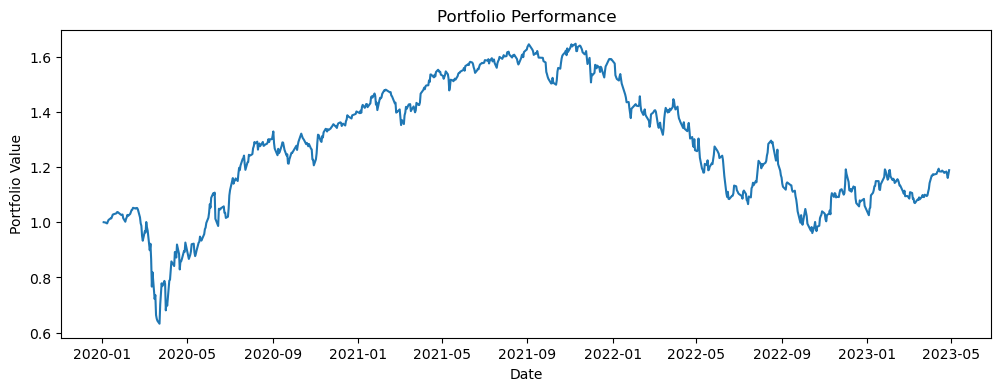

Max Drawdown: -0.41670888589853217
Turnover: 1.062058681695
returns: 18.84728204938706


,ACWI,BOND,REET,USO,GLO,SPY,EWY,GOVT,LQD,VTV,...,223190,325020,SHV,TLH,VCSH,VCLT,SRVR,XHB,SLV,JPST
2020-01-03,0.16667,0.16667,0.16667,0.16667,0.066668,0.091527,0.075143,0.066668,0.100002,0.009153,...,0.052600,0.007514,0.046668,0.020000,0.060001,0.040001,0.100002,0.066668,0.100002,0.16667
2020-01-31,0.16667,0.16667,0.16667,0.16667,0.100002,0.100002,0.066668,0.066668,0.100002,0.010000,...,0.013334,0.046668,0.046668,0.020000,0.060001,0.040001,0.066668,0.100002,0.066668,0.16667
2020-03-31,0.10000,0.70000,0.00000,0.00000,0.000000,0.060000,0.040000,0.420000,0.280000,0.006000,...,0.008000,0.004000,0.210000,0.210000,0.168000,0.112000,0.000000,0.000000,0.000000,0.20000
2020-06-30,0.10028,0.69965,0.00030,0.00020,0.000000,0.040112,0.060168,0.419790,0.279860,0.004011,...,0.006017,0.042118,0.293853,0.125937,0.167916,0.111944,0.000180,0.000120,0.000000,0.19992
2020-07-31,0.16667,0.16667,0.16667,0.16667,0.066668,0.066668,0.100002,0.066668,0.100002,0.033334,...,0.010301,0.069999,0.046668,0.020000,0.060001,0.040001,0.066668,0.100002,0.100002,0.16667
2020-08-31,0.16667,0.16667,0.16667,0.16667,0.100002,0.100002,0.066668,0.100002,0.066668,0.016667,...,0.046668,0.006667,0.050001,0.050001,0.040001,0.026667,0.066668,0.100002,0.066668,0.16667
2020-11-30,0.16667,0.16667,0.16667,0.16667,0.100002,0.066668,0.100002,0.066668,0.100002,0.006667,...,0.023384,0.059197,0.046668,0.020000,0.050001,0.050001,0.066668,0.100002,0.066668,0.16667
2021-03-31,0.16667,0.16667,0.16667,0.16667,0.100002,0.100002,0.066668,0.066668,0.100002,0.010000,...,0.046668,0.006667,0.033334,0.033334,0.060001,0.040001,0.066668,0.100002,0.066668,0.16667
2021-04-30,0.16667,0.16667,0.16667,0.16667,0.066668,0.100002,0.066668,0.100002,0.066668,0.014588,...,0.013334,0.046668,0.050001,0.050001,0.040001,0.026667,0.100002,0.066668,0.100002,0.16667
2021-06-30,0.16667,0.16667,0.16667,0.16667,0.100002,0.066668,0.100002,0.066668,0.100002,0.006667,...,0.033334,0.033334,0.033334,0.033334,0.050001,0.050001,0.066668,0.100002,0.066668,0.16667


In [19]:
# Load asset prices
loader = Loader("./sample_2.csv")

universe = Tree("Universe")
universe.insert("Universe", "ACWI", weight_bounds = (0.1, 0.8))
universe.insert("Universe", "BOND", weight_bounds = (0.1, 0.8))
universe.insert("Universe", "REET", weight_bounds = (0, 0.5))
universe.insert("Universe", "USO", weight_bounds = (0, 0.5))
universe.insert("Universe", "GLO", weight_bounds = (0, 0.5))
universe.insert("Universe", "JPST", weight_bounds = (0, 0.2))

universe.insert("ACWI", "SPY", weight_bounds = (0.1, 0.6))
universe.insert("ACWI", "EWY", weight_bounds = (0.1, 0.6))

universe.insert("BOND", "GOVT", weight_bounds = (0.1, 0.6))
universe.insert("BOND", "LQD", weight_bounds = (0.1, 0.6))

universe.insert("SPY", "VTV", weight_bounds = (0.1, 0.7))
universe.insert("SPY", "VUG", weight_bounds = (0.1, 0.7))
universe.insert("SPY", "VYM", weight_bounds = (0.1, 0.7))
universe.insert("SPY", "MTUM", weight_bounds = (0.1, 0.7))
universe.insert("SPY", "SPLV", weight_bounds = (0.1, 0.7))
universe.insert("SPY", "QUAL", weight_bounds = (0.1, 0.7))

universe.insert("EWY", "325010", weight_bounds = (0.1, 0.7))
universe.insert("EWY", "223190", weight_bounds = (0.1, 0.7))
universe.insert("EWY", "325020", weight_bounds = (0.1, 0.7))

universe.insert("GOVT", "SHV", weight_bounds = (0.1, 0.7))
universe.insert("GOVT", "TLH", weight_bounds = (0.1, 0.7))

universe.insert("LQD", "VCSH", weight_bounds = (0.4, 0.7))
universe.insert("LQD", "VCLT", weight_bounds = (0.4, 0.7))

universe.insert("GLO", "GLO", weight_bounds = (0.4, 0.6))
universe.insert("GLO", "SLV", weight_bounds = (0.4, 0.6))

universe.insert("REET", "SRVR", weight_bounds = (0.4, 0.6))
universe.insert("REET", "XHB", weight_bounds = (0.4, 0.6))

"""universe = Tree("Universe")
universe.insert("Universe", "ACWI")
universe.insert("Universe", "BOND")
universe.insert("Universe", "REET")
universe.insert("Universe", "USO")
universe.insert("Universe", "GLO")

universe.insert("ACWI", "SPY")
universe.insert("ACWI", "EWY")

universe.insert("BOND", "GOVT")
universe.insert("BOND", "LQD")

universe.insert("SPY", "VTV")
universe.insert("SPY", "VUG")
universe.insert("SPY", "VYM")
universe.insert("SPY", "MTUM")
universe.insert("SPY", "SPLV")
universe.insert("SPY", "QUAL")

universe.insert("EWY", "325010")
universe.insert("EWY", "223190")
universe.insert("EWY", "325020")

universe.insert("GOVT", "SHV")
universe.insert("GOVT", "TLH")

universe.insert("LQD", "VCSH")
universe.insert("LQD", "VCLT")

universe.insert("GLO", "GLO")
universe.insert("GLO", "SLV")

universe.insert("REET", "SRVR")
universe.insert("REET", "XHB")"""


pipe = pipeline([("SAA", risk_parity_optimizer), ("TAA", mean_variance_optimizer), ("AP", risk_parity_optimizer)], universe)
assumption = AssetAssumption(returns=(historical_return, {'window': 10}), covariance=(historical_covariance, {'window': 10}))

# Create a Backtest object
backtest = Backtest(pipeline=pipe,
    loader=loader,
    assumption=assumption,
    start_date="2020-01-03",
    end_date="2023-05-01",
)


# Run the backtest
backtest.run_backtest()

# Plot the performance
backtest.plot_performance()

# Calculate maximum drawdown and turnover
max_drawdown = backtest.calculate_maximum_drawdown()
turnover = backtest.calculate_turnover()
asset_weights = backtest.asset_weights
returns = backtest.calculate_return()

print("Max Drawdown:", max_drawdown)
print("Turnover:", turnover)
print("returns:", (returns[-1]-1)*100)
asset_weights

<AxesSubplot:>

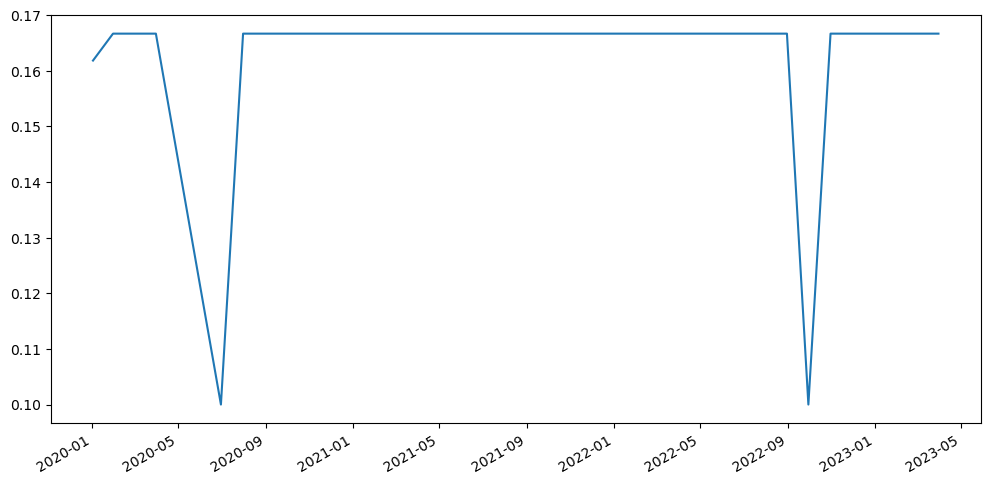

In [228]:
asset_weights['ACWI'].plot(figsize=(12,6))

In [229]:
backtest.calculate_return()

Date
2020-01-03    1.000000
2020-01-06    0.998397
2020-01-07    0.996183
2020-01-08    0.995902
2020-01-09    1.002860
                ...   
2023-04-24    1.245063
2023-04-25    1.234642
2023-04-26    1.221962
2023-04-27    1.235967
2023-04-28    1.250641
Length: 795, dtype: float64

In [186]:
universe.draw()

`-- Universe
    |-- ACWI
    |   |-- SPY
    |   |   |-- VTV
    |   |   |-- VUG
    |   |   |-- VYM
    |   |   |-- MTUM
    |   |   |-- SPLV
    |   |   `-- QUAL
    |   `-- EWY
    |       |-- 325010
    |       |-- 223190
    |       `-- 325020
    |-- BOND
    |   |-- GOVT
    |   |   |-- SHV
    |   |   `-- TLH
    |   `-- LQD
    |       |-- VCSH
    |       `-- VCLT
    |-- REET
    |   |-- SRVR
    |   `-- XHB
    |-- USO
    |-- GLO
    |   |-- GLO
    |   `-- SLV
    `-- JPST


In [154]:
df = loader.load_data('2018-07-21', '2023-04-28')

In [155]:
df = df.pct_change().dropna()

In [156]:
df

,ACWI,BOND,REET,USO,GLO,SPY,EWY,GOVT,LQD,VTV,...,325010,223190,325020,SHV,TLH,VCSH,VCLT,SRVR,XHB,SLV
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-03,0.001855,-0.000657,0.005671,-0.009910,0.003240,-0.002543,0.018895,0.002339,0.000000,0.009500,...,0.011095,0.017329,0.016023,-0.001627,0.003458,0.000000,-0.000858,-0.003103,0.014338,0.016117
2019-06-04,0.016235,0.000564,-0.003759,0.015469,0.010764,0.021707,0.007065,-0.003501,0.000331,0.019962,...,-0.003556,-0.002493,0.001118,-0.000091,-0.006258,-0.000999,-0.002040,-0.000208,0.030069,0.001442
2019-06-05,0.003503,0.000563,0.014717,-0.034946,0.000000,0.008662,-0.009996,-0.001171,-0.000662,0.006151,...,0.003569,0.002499,-0.002570,0.000362,-0.001840,0.001124,-0.001829,0.023042,0.005988,-0.000720
2019-06-07,0.015920,0.001595,0.006694,0.042711,0.006390,0.016575,0.009035,0.003126,0.006375,0.011208,...,-0.004064,0.000415,-0.002912,0.000272,0.007231,0.000874,0.010887,0.005512,0.008929,0.012968
2019-06-10,0.004261,-0.002155,-0.002216,-0.010686,0.008466,0.004589,0.009129,-0.002727,-0.003620,0.003206,...,0.017343,0.014535,0.015951,0.000181,-0.007249,-0.000748,-0.002986,0.001917,0.004425,-0.019915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.000434,0.003462,-0.002176,0.015247,-0.004193,0.001043,-0.006498,0.003871,0.004404,0.002994,...,-0.008016,-0.005104,-0.007339,0.000091,0.007187,0.001707,0.005943,-0.000678,0.002593,0.004352
2023-04-25,-0.016050,0.004851,-0.010467,-0.023538,-0.008421,-0.015874,-0.028286,0.008569,0.004384,-0.011015,...,-0.018996,-0.008062,-0.002856,0.000272,0.014096,0.003277,0.006914,-0.013569,-0.014801,-0.003899
2023-04-26,-0.002535,-0.003433,-0.003967,-0.033422,0.016985,-0.004236,0.005553,-0.003823,-0.004365,-0.012862,...,-0.000723,-0.004644,-0.003707,0.000091,-0.007384,-0.001306,-0.007740,-0.002063,-0.014148,-0.006960


# 잠시 샘플 데이터 크롤링해서 만들기

In [166]:
import pandas as pd
import FinanceDataReader as fdr
# 회사채 : 136340, 국공채 : 272560, 미국주식 : 379780, 한국주식 : 148020
# 주식 : 189400 채권 : 267440
ticker=['189400', '267440', '379780', '148020', '136340', '272580']
piesta = ['ACWI', 'BOND', 'REET', 'USO', 'GLO', 'SPY', 'EWY', 'GOVT', 'LQD',
         'VTV', 'VUG', 'VYM', 'MTUM', 'SPLV', 'QUAL', '325010', '223190', '325020',
         'SHV', 'TLH', 'VCSH', 'VCLT', 'SRVR', 'XHB', 'SLV', 'JPST']

In [167]:
def get_ticker_data(tickers):
    df = dict()
    name = ['ACWI', 'BOND', 'REET', 'USO', 'GLO', 'SPY', 'EWY', 'GOVT', 'LQD',
         'VTV', 'VUG', 'VYM', 'MTUM', 'SPLV', 'QUAL', '325010', '223190', '325020',
         'SHV', 'TLH', 'VCSH', 'VCLT', 'SRVR', 'XHB', 'SLV', 'JPST']
    #name = ['Stocks', 'Bonds', 'US Stocks', 'Korean Stocks', 'Government Bonds', 'Corporate Bonds']
    for i in range(len(name)):
        df[name[i]] = fdr.DataReader(piesta[i], '2010')['Close']
        print(f"{name[i]} 시작일 {df[name[i]].index[0]}")
        #print(df[name[i]])
        
        
    return pd.DataFrame(df).dropna()

In [168]:
#fdr.DataReader('EWY', '2010')['Close']

In [169]:
sample = get_ticker_data(ticker)
sample.to_csv('sample_2.csv')

ACWI 시작일 2010-01-04 00:00:00
BOND 시작일 2012-03-01 00:00:00
REET 시작일 2014-07-10 00:00:00
USO 시작일 2010-01-04 00:00:00
GLO 시작일 2010-01-04 00:00:00
SPY 시작일 2010-01-04 00:00:00
EWY 시작일 2010-01-04 00:00:00
GOVT 시작일 2012-02-24 00:00:00
LQD 시작일 2010-01-04 00:00:00
VTV 시작일 2010-01-04 00:00:00
VUG 시작일 2010-01-04 00:00:00
VYM 시작일 2010-01-04 00:00:00
MTUM 시작일 2013-04-18 00:00:00
SPLV 시작일 2011-05-05 00:00:00
QUAL 시작일 2013-07-18 00:00:00


C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


325010 시작일 2019-05-31 00:00:00
223190 시작일 2015-06-26 00:00:00
325020 시작일 2019-05-31 00:00:00


C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


SHV 시작일 2010-01-04 00:00:00
TLH 시작일 2010-01-04 00:00:00
VCSH 시작일 2010-01-04 00:00:00
VCLT 시작일 2010-01-04 00:00:00
SRVR 시작일 2018-05-16 00:00:00
XHB 시작일 2010-01-04 00:00:00
SLV 시작일 2010-01-04 00:00:00
JPST 시작일 2017-05-19 00:00:00


In [23]:
a = {'a':1, 'b':2}

for key, value in a.items():
    print(key, value)

a 1
b 2


In [24]:
df.loc['2021-07-22', 'Stocks']

0.011534025374855927

In [304]:
sample

,ACWI,BOND,REET,USO,GLO,SPY,EWY,GOVT,LQD,VTV,...,325010,223190,325020,SHV,TLH,VCSH,VCLT,SRVR,XHB,SLV
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,70.089996,106.510002,26.450001,88.800003,9.26,275.269989,55.570000,25.650000,120.830002,104.209999,...,9734.0,7098.0,8800.0,110.610001,141.720001,80.120003,93.209999,29.000000,38.360001,13.650000
2019-06-03,70.220001,106.440002,26.600000,87.919998,9.29,274.570007,56.619999,25.709999,120.830002,105.199997,...,9842.0,7221.0,8941.0,110.430000,142.210007,80.120003,93.129997,28.910000,38.910000,13.870000
2019-06-04,71.360001,106.500000,26.500000,89.279999,9.39,280.529999,57.020000,25.620001,120.870003,107.300003,...,9807.0,7203.0,8951.0,110.419998,141.320007,80.040001,92.940002,28.903999,40.080002,13.890000
2019-06-05,71.610001,106.559998,26.889999,86.160004,9.39,282.959991,56.450001,25.590000,120.790001,107.959999,...,9842.0,7221.0,8928.0,110.459999,141.059998,80.129997,92.769997,29.570000,40.320000,13.880000
2019-06-07,72.750000,106.730003,27.070000,89.839996,9.45,287.649994,56.959999,25.670000,121.559998,109.169998,...,9802.0,7224.0,8902.0,110.489998,142.080002,80.199997,93.779999,29.733000,40.680000,14.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,92.190002,92.760002,23.250000,64.389999,4.76,412.850006,61.060001,23.410000,108.570000,137.500000,...,13840.0,9540.0,11930.0,110.190002,113.169998,76.419998,78.199997,29.410000,71.180000,23.309999
2023-05-11,91.959999,92.930000,23.040001,63.250000,4.78,412.130005,60.060001,23.480000,108.989998,136.919998,...,13760.0,9540.0,11935.0,110.230003,114.019997,76.480003,78.769997,29.160000,71.129997,22.200001
2023-05-12,91.699997,92.510002,22.920000,62.070000,4.75,411.589996,59.270000,23.370001,108.320000,136.889999,...,13710.0,9470.0,11855.0,110.230003,113.180000,76.290001,78.059998,29.200001,70.790001,22.020000


In [153]:
sample.index

NameError: name 'sample' is not defined